In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import get_data, binning, int_to_str_time#, Union
random.seed(2024)

Text(0.5, 1.0, 'Distribution of Marathon Finish Times')

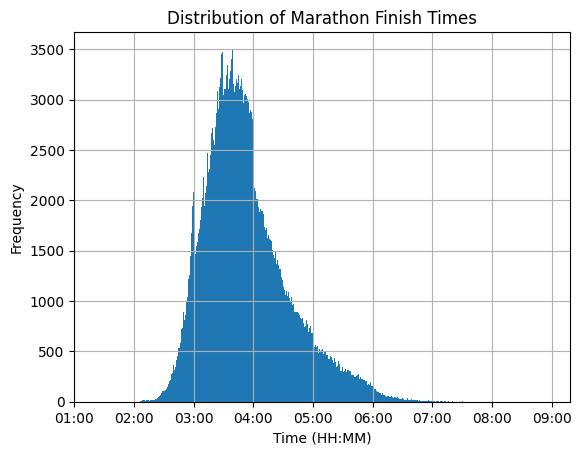

In [2]:
train2, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=286777,train_tup=(0, 2023), size_test=400)
ticks = (60, 120, 180, 240, 300, 360, 420, 480, 540)
minutes_dist = ((42195 / 60) / train2[train2["dist"] == "5K"]["finish"]) // 1
bins = binning(minutes_dist)
minutes_dist.hist(bins=bins)
labels = [int_to_str_time(t) for t in ticks]
plt.xticks(ticks, labels=labels)
plt.xlabel(f"Time (HH:MM)")
plt.ylabel("Frequency")
plt.title(f"Distribution of Marathon Finish Times")
# plt.savefig(f"analysis/plot_dist2.png")

In [3]:
table1 = train2[train2["dist"].isin(["10K", "20K", "30K"])]
table1[["total_pace", "finish"]] = table1[["total_pace", "finish"]].apply(lambda x: (42195 / 60) / x)
table1

/var/folders/fg/rrlp0jyd0yx58b9sdy3mnbkm0000gn/T/ipykernel_44327/2759799423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table1[["total_pace", "finish"]] = table1[["total_pace", "finish"]].apply(lambda x: (42195 / 60) / x)


,id,dist,curr_pace,total_pace,finish,age,gender,year,prop
286777,0,10K,5.586592,124.404925,128.700000,28,M,2009,0.236995
286778,1,10K,5.580357,124.475250,129.533333,30,M,2009,0.236995
286779,2,10K,5.586592,124.404925,129.666667,26,M,2009,0.236995
286780,3,10K,5.586592,124.404925,129.816667,27,M,2009,0.236995
286781,4,10K,5.586592,124.404925,130.100000,20,M,2009,0.236995
...,...,...,...,...,...,...,...,...,...
1720657,286772,30K,1.435544,400.219575,415.816667,61,M,2022,0.710985
1720658,286773,30K,1.537515,386.084250,416.583333,58,M,2022,0.710985
1720659,286774,30K,1.488982,394.288833,418.200000,51,M,2022,0.710985
1720660,286775,30K,1.219215,416.488092,418.833333,61,M,2022,0.710985


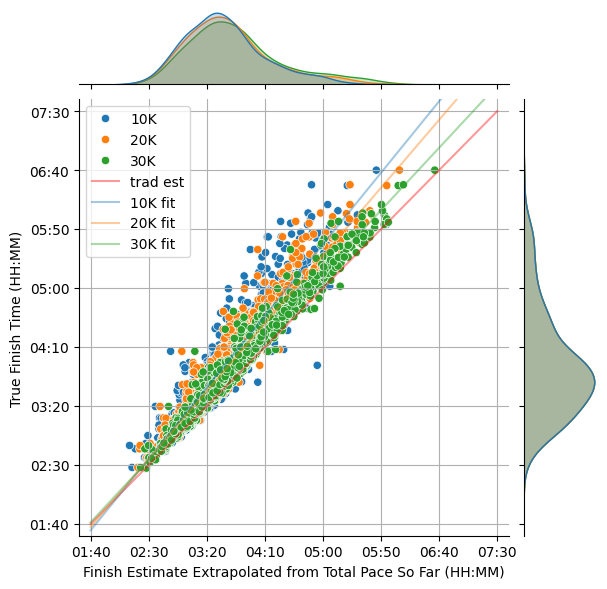

In [4]:
from utils import int_to_str_time
np.random.seed(2024)
train_ids = np.random.choice(np.array(list(set(table1["id"]))), 1000, replace=False)
table2 = table1[table1["id"].isin(train_ids)]

sns.jointplot(data=table2, x="total_pace", y="finish", hue="dist")
plt.plot([100, 450], [100, 450], color="red", label='trad est', alpha=0.4)
plt.xlabel("Finish Estimate Extrapolated from Total Pace So Far (HH:MM)")
plt.ylabel("True Finish Time (HH:MM)")

ticks = (100, 150, 200, 250, 300, 350, 400, 450)
labels = [int_to_str_time(t) for t in ticks]
plt.xticks(ticks, labels=labels)
plt.yticks(ticks, labels=labels)


for dist, color in [("10K", "blue"), ("20K", "orange"), ("30K", "green")]:
    small_data = table2[table2["dist"] == dist]#[["total_pace", "finish"]]
    m, b = np.polyfit(small_data["total_pace"], small_data["finish"], 1)
    x = np.array([100, 450])
    plt.plot(x, m*x + b, alpha=0.4, label=f"{dist} fit")

plt.ylim(90, 460)
plt.xlim(90, 460)
# plt.title("Comparing Extrapolated Estimates to True Finish At Different Stages of Race")
plt.grid()
plt.legend()
plt.savefig("analysis/data_scatter.png", bbox_inches="tight")